## 1. Intro : Breaking RSA encryption and Order Finding

- Goal: Demonstrate how RSA encryption can be broken with a quantum computer (with Shor's algorithm) and compare it to classical methods.
- In RSA, factoring the product of two primes becomes feasible once we find the order of a co-prime number a modulo n. In Quantum Computing, Shor's algorithm enables this through quantum phase estimation (QPE).


# Python Imports

In [18]:
from math import gcd
import math
from fractions import Fraction
import pandas as pd
import numpy as np
import time

# Quantum Programming
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram

# Plotting (for visualization)
from matplotlib import pyplot as plt

## 2. Classical Order Finding (3-4 min)

In [19]:
# Adapted code from lecture 14 solution
def classical_order_finding(a, n):
    assert gcd(a, n) == 1
    
    t0 = time.time()
    power = a
    r = 1      
    while power != 1:
        r += 1
        power = pow(power, r, n)
        
    t = time.time() - t0   
    return r, t, r  # r = iteration count

"""Notice:
Order size (= power) does not correlate directly with n 
- Some large n value still yield small r
- Below pair of numbers are picked to show 
how classical algorithm struggles when orders (iterations) get higher
- Normally more orders ≠ proportionally more run time
"""
a, n = 2, 15
r, t, _ = classical_order_finding(a, n)
print(f"Total run-time to find order {r} of {a} mod {n} = {t:.3f}s")
#for a, n in [[2, 15], [2, 1019], [2, 153488707270219], [2, 3416178076769076332873], [2, 10057227701218939403237]]:
    #r, t = classical_order_finding(a, n)
    #print(f"Total run-time to find order {r} of {a} mod {n} = {t:.3f}s")


Total run-time to find order 4 of 2 mod 15 = 0.000s


In [20]:
# Use this to see the cycle (periodicity)
def get_modular_exponentiation_sequence (a, n, max_power=10):
    powers = np.arange(0, max_power)
    result = [pow(a, int(r), n) for r in powers]  
    output_df = pd.DataFrame({"sequence": result})
    output_df.index.name = "power"
    return output_df

# Example of order of 2 mod 15
get_modular_exponentiation_sequence(2, 15)
#order = df[df['sequence'] == 1].index[1] # skip power=0
#print("Classical order r =", order)

,sequence
power,
0,1
1,2
2,4
3,8
4,1
5,2
6,4
7,8
8,1


## 3. Quantum Order Finding with Shor's Algorithm
### 3.1 Overview of Shor's Algorithm
1. Choose a random a < n such that gcd(a, n) = 1
2. Use Quantum Phase Estimation (QPE) to find the order `r`
3. Use classical post-processing to extract factors (p,q)

### 3.2 Circuit: Modular Multiplication Gate `U`
We define a unitary operator `U |b⟩ = |a * b mod n⟩`.
This gate is used in the QPE circuit to encode the periodicity.

In [21]:
# Utility function to build U |b⟩ = |a * b mod n⟩
def modular_multiplication_gate_U(a, n, label=None):
    dimension = 2 ** math.ceil(math.log2(n)) # Find the smallest power of 2 >= n (2**k, k qubits)
    U = np.zeros((dimension, dimension)) # initialize with 0s
    
    for b in range(n):
      ab_mod_n = (a * b) % n
      U[ab_mod_n, b] = 1
      
    # Fill rest with identity to make U unitary
    for i in range(n, dimension):
      U[i, i] = 1
      
    return UnitaryGate(U, label=label or f"U{a} mod {n}")

The order finding circuit


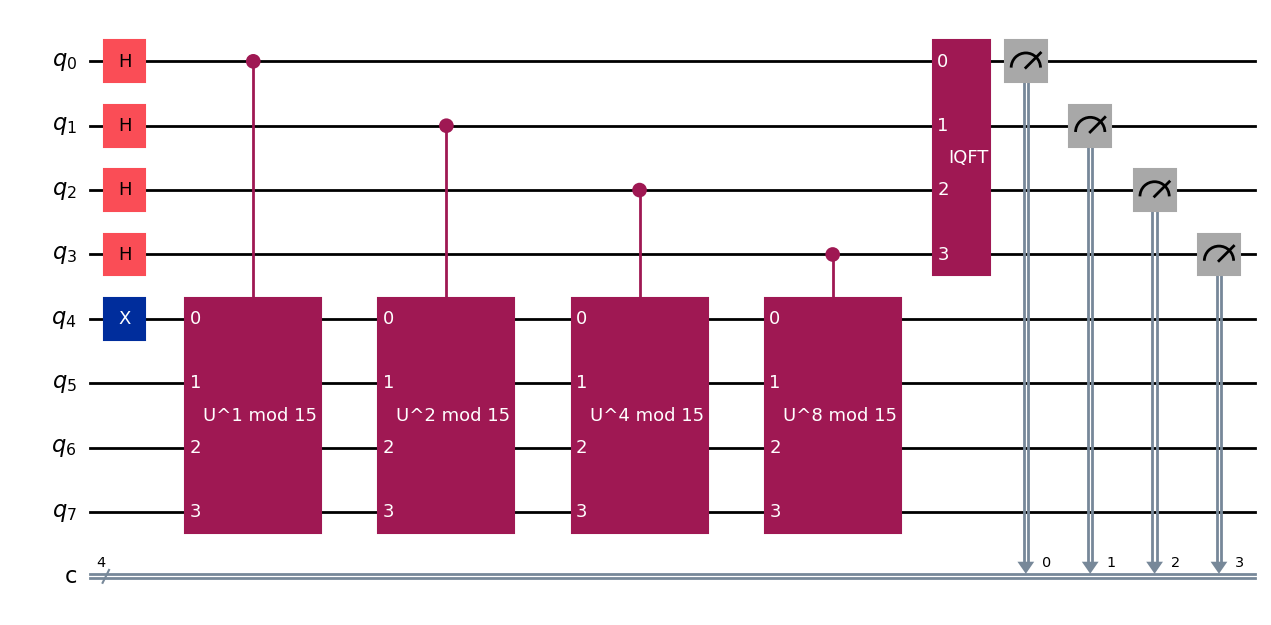

In [22]:
# Adapted code from lecture 14 excercise solution
def qpe_order_finding_circuit(a, n, t):
      # determin number of qubits needed
      counting_qubits = t
      target_qubits = math.ceil(math.log2(n)) # Enough to represent n 
      qc = QuantumCircuit(counting_qubits + target_qubits, counting_qubits)
      
      # Prepare target register in the eigenstate |1>
      qc.x(counting_qubits) # Apply X gate to the least significant bit of target
      
      # Apply Hadamards on counting qubits 
      for qubit in range(counting_qubits):
            qc.h(qubit)
      
      # Apply controlled modular multiplication gates
      for j in range(counting_qubits):
            exponent = 2**j
            mod_base = pow(a, exponent, n)
            control = j
            target = list(range(counting_qubits, counting_qubits + target_qubits))
            U = modular_multiplication_gate_U(mod_base, n, label=f"U^{exponent} mod {n}").control()
            qc.append(U, [control] + target) 
      
      # Apply inverse QFT
      qc.append(QFT(counting_qubits, do_swaps=True).inverse(), range(counting_qubits))
      
      # Measure counting register
      qc.measure(range(counting_qubits), range(counting_qubits))
      
      return qc


# Show the circuit (how the QPE works)
print("The order finding circuit")
qc = qpe_order_finding_circuit(a=2, n=15, t=4)
qc.draw('mpl')

### 3.3 Quantum Phase Estimation
We apply QPE using the `U` gate to extract the phase, which relates to `r`.

In [23]:
# Build and simulate QPE circuit using Qiskit
def quantum_order_finding(a, n, t=4):  
    qc = qpe_order_finding_circuit(a, n, t) 
    # Simulate the quantum order finding circuit
    shots = 100 
    simulator = Aer.get_backend('aer_simulator') # simulate quantum circuits on a classical computer
    qc_sim = transpile(qc, simulator)
    result = simulator.run(qc_sim, shots=shots).result()
    counts = result.get_counts()
    most_common = max(counts, key=counts.get) # Find the most frequently measured bitstring (phase)
    phase = int(most_common, 2) / 2**t # get decimal approximation of the phase
    frac = Fraction(phase).limit_denominator(n) # convert decimal phase into s/r, using continued fractions
    r = frac.denominator # extract r (= order of a modulo n)

    return {
        "shots": shots,
        "estimated_order": r,
        "phase": phase,
        "fraction": frac,
        "counts": counts,
        "circuit": qc_sim
        }

### 3.4 Results and Visualization

Result of running the circuit 100 times: 
Most common outcome: 1000
Estimated Phase: 0.5
Fractional Estimate: 1/2 (s/r)
Extracted order r = 2


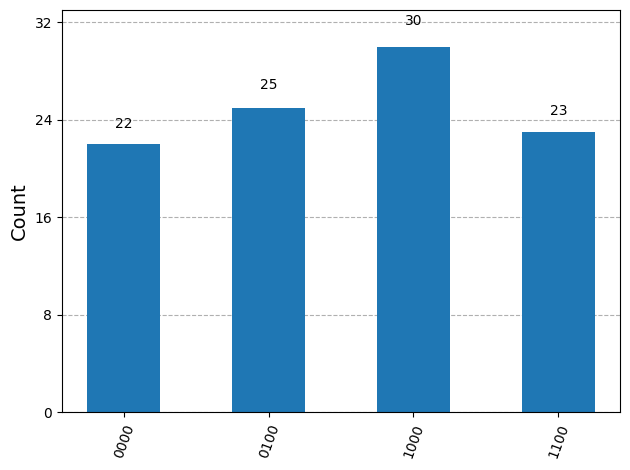

In [24]:
# Show the measurement(probability distribution of bitstrings) result
res = quantum_order_finding(a=2, n=15)
print(f"Result of running the circuit {res['shots']} times: ")
# Summary
print(f"Most common outcome: {max(res['counts'], key=res['counts'].get)}")
print(f"Estimated Phase: {res['phase']}")
print(f"Fractional Estimate: {res['fraction']} (s/r)")
print(f"Extracted order r = {res['estimated_order']}")
plot_histogram(res['counts']) 

# Discrepancy (Limitation of QPE)
# Result can be incorrect because we simulated with 4 qubits.(limited qubits)
# We must verify the extimated `r` classically, and rerun the circuit

## [Optional] 4. Classical vs Quantum Order Finding

In [25]:
qc = res['circuit']
print("Total Qubits:", qc.num_qubits)
print("Circuit Depth:", qc.depth())
print("Gate Counts:", qc.count_ops())

Total Qubits: 8
Circuit Depth: 2078
Gate Counts: OrderedDict({'unitary': 1094, 'cx': 1051, 'u3': 26, 'h': 6, 'cp': 6, 'measure': 4, 'diagonal': 2, 'x': 1})


In [26]:
# Comparison
a = 2
n = 15

# Classical
r_classical, time_classical, iterations = classical_order_finding(a, n)

# Quantum
res_quantum = quantum_order_finding(a, n)
r_quantum = res_quantum["estimated_order"]
n_qubits = res_quantum["circuit"].num_qubits
gate_depth = res_quantum["circuit"].depth()

comparison_df = pd.DataFrame([
    {
    "Method": "Classical",
    "Estimated Order": r_classical,
    "Runtime (s)": round(time_classical, 6),
    "Iteration Count": iterations,
    "Qubits": "N/A",
    "Gate Depth": "N/A",
    "Shots": "N/A",
    "Success Guarantee": "Yes"
    }, 
    {
    "Method": "Quantum",
    "Estimated Order": r_quantum,
    "Runtime (s)": "Not meaningful (100 shots)",
    "Iteration Count": "N/A",
    "Qubits": n_qubits,
    "Gate Depth": gate_depth,
    "Shots": 100,
    "Success Guarantee": "Probabilistic"
    }
])

display(comparison_df)


,Method,Estimated Order,Runtime (s),Iteration Count,Qubits,Gate Depth,Shots,Success Guarantee
0,Classical,4,0.000003,4,N/A,N/A,N/A,Yes
1,Quantum,4,Not meaningful (100 shots),N/A,8,2078,100,Probabilistic


## 5. Conlusion: Limitation and Final Thoughts (1 min)
RSA encryption is **theoretically breakable** using quantum computing via Shor's algorithm, which finds the order `r` of a number `a` modulo `n`. Our simulation demonstrated QPE can extrct the phace and convert it into `r` via continued fractions.

However, real-world RSA encryption (e.g., 2048-bit keys) is still safe today duo to major quantum hardware limitations: 

- **Qubit Count** : Large-scale order finding requires thousands of logical qubits. Today's device support only ~100 noisy qubits.
- **Coherence Tme** : Quantum lose their quantum state quickly (microseconds), while Shor's circuits are deep and long.
- **Gate Fidelity** : Imperfect gates causes accumulated errors. Modular multiplication involves many layers of Unitary and CNOT(cx) gates.

These challenges make it currently **impractical to run Shor's algorithm on quantum computers.**

As hardware improves, **error correction** and **fault-tolerant quantum computing** may help overcom these barriers.

At the same time, reserch in **Post-quantum cryptography** is also developing new encryption methods that are resistant to quantum attacks.

In conclusion, 
- Shor's algorithm theoretically enables a quantum speedup for breaking RSA.
- It is **not yet** a threat to real-world RSA, but that future is **approaching**.